In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA

import scipy.stats as stats
from scipy.stats import beta

import pymc3 as pm
import arviz as az

In [2]:
movies = pd.read_csv('../data/movies_1990_2020_with_detail_oscars_complete.csv', index_col='tconst', low_memory=False)

In [3]:
X_vars_all = ['runtimeMinutes', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 
       'Warner Bros.', 'Universal Pictures', 'Columbia Pictures',
       'Paramount Pictures', 'Dreamworks Pictures', 'Walt Disney Pictures',
       'Miramax', 'Twentieth Century Fox', 'New Line Cinema', 'Focus Features',
       'Fox Searchlight Pictures', 'Touchstone Pictures',
       'Walt Disney Animation Studios', 'BBC Films', 'TriStar Pictures',
       'New Regency Productions', 'Fox 2000 Pictures', 'The Weinstein Company',
       'Annapurna Pictures', 'Castle Rock Entertainment',
        'oscars_post_release', 'US_open_WE', 'prev_Oscars_f', 'rel_USA', 'prev_Oscar_wins_nm', 'prev_Oscar_noms_nm',
       'rel__aug', 'rel__dec', 'rel__feb', 'rel__jan', 'rel__jul', 'rel__jun',
       'rel__mar', 'rel__may', 'rel__nov', 'rel__oct', 'rel__sep', 'budget_USD']

In [4]:
tconst_title = e.loade.load(open('../pickles/tconst_title.p', 'rb'))
tconst_year = pickle.load(open('../pickles/tconst_year.p', 'rb'))

In [5]:
stan = StandardScaler()

X = stan.fit_transform(movies[X_vars_all])

pca = PCA(n_components = 2)
movies_pca = pca.fit_transform(X)

movies_pca_db_df = pd.DataFrame(index = movies.index, data = movies_pca)
movies_pca_db_df['title'] = movies_pca_db_df.index.map(tconst_title)
movies_pca_db_df['year']= movies_pca_db_df.index.map(tconst_year)
movies_pca_db_df = movies_pca_db_df.merge(movies['Oscars'], left_index = True, right_index = True, how = 'left')

movies_pca_db_df.rename(columns = {0: 'pca1', 1: 'pca2'}, inplace = True)
movies_pca_db_df['GG']=movies['GG']

movies_pca_db_df.head(5)

,pca1,pca2,title,year,Oscars,GG
tconst,,,,,,
tt0015414,-0.705611,0.571153,La tierra de los toros,2000.0,0,0.0
tt0015724,-0.161634,-2.083408,Dama de noche,1993.0,0,0.0
tt0016906,-0.544298,1.238380,Frivolinas,2014.0,0,0.0
tt0019996,-0.542016,0.107189,Hongxia,2011.0,0,0.0
tt0035423,6.718399,-1.435780,Kate & Leopold,2001.0,1,1.0


In [6]:
movies_pca_db_df[movies_pca_db_df['title']=='Ammonite']

,pca1,pca2,title,year,Oscars,GG
tconst,,,,,,
tt7983894,11.942835,2.869009,Ammonite,2020.0,0,0.0


In [7]:
movies_pca_db_df.loc['tt7983894','pca1']

11.942834911787717

In [8]:
movies_pca_db_df['dist_to_amm'] = movies_pca_db_df.apply(lambda x: ((x.pca1-movies_pca_db_df.loc['tt7983894','pca1'])**2 
                                                         + (x.pca2-movies_pca_db_df.loc['tt7983894','pca2'])**2 )**0.5, axis = 1)

(0.0, 20.0)

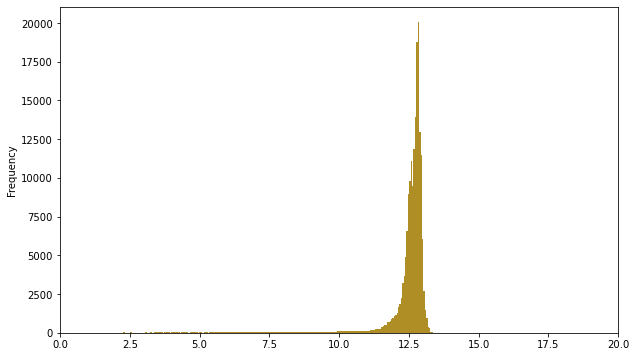

In [9]:
movies_pca_db_df['dist_to_amm'].plot(kind = 'hist', bins = 1000, figsize = (10,6), color = '#ae8e25');
plt.xlim(0,20)

In [10]:
like_ammonite = movies_pca_db_df[movies_pca_db_df['dist_to_amm']<=3].sort_values(['dist_to_amm'])
like_ammonite.head()

,pca1,pca2,title,year,Oscars,GG,dist_to_amm
tconst,,,,,,,
tt7983894,11.942835,2.869009,Ammonite,2020.0,0,0.0,0.000000
tt0117791,11.908600,2.756554,Surviving Picasso,1996.0,0,0.0,0.117551
tt0810819,11.979622,2.690574,The Danish Girl,2015.0,1,1.0,0.182188
tt0281373,11.948942,2.628950,Snow Dogs,2002.0,0,0.0,0.240137
tt0120102,12.118405,2.704813,Seven Years in Tibet,1997.0,0,1.0,0.240386


#### **Prior**: Approx. 1 in 1000 movies made each year gets nominated for an Academy Award

(0.0, 0.02)

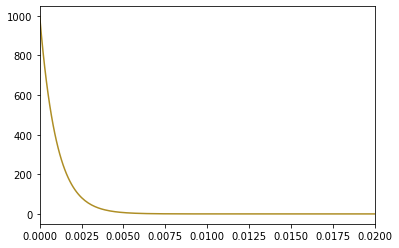

In [33]:
alpha_prior = 1 # number of nominated movies 
beta_prior = 999 - alpha_prior # number of movies which did not get nominated
prior_1 = stats.beta(alpha_prior, beta_prior) # distribution based on this limited knowledge

plt.plot(np.linspace(0, 1, 10000), prior_1.pdf(np.linspace(0, 1, 10000)), color = '#ae8e25');
plt.xlim(0,0.02)

#### **Likelihood**: Approx. 1 in 2 movies made each year gets nominated for a Golden Globe given also being nominated for an Academy Award

(0.0, 1.0)

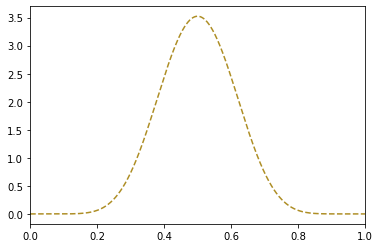

In [21]:
alpha_lhood = 10 # number of movies nominated for Golden globe if also nominated for Oscar 
beta_lhood = 10 #  number of movies nominated for Golden globe if not nominated for Oscar 
lhood = stats.beta(alpha_lhood, beta_lhood) # distribution based on this limited knowledge

plt.plot(np.linspace(0, 1, 10000), lhood.pdf(np.linspace(0, 1, 10000)), color = '#ae8e25', ls = '--');
plt.xlim(0,1)

#### **Posterior**: probability of a movie getting nominated for an Academy Award given that it was nominated for a Golden Globe

In [59]:
class prior:
    def __init__(self, alpha0=1, alpha1=1):
        """Beta prior for binary data."""

        self.a0 = alpha0
        self.a1 = alpha1
        self.p0rv = beta(self.a0, self.a1)

    def interval(self, prob):
        """End points for region of pdf containing `prob` of the
        pdf-- this uses the cdf and inverse.

        Ex: interval(0.95)
        """

        return self.p0rv.interval(prob)

    def mean(self):
        """Returns prior mean."""

        return self.p0rv.mean()

    def pdf(self, p0):
        """Probability density at p0."""

        return self.p0rv.pdf(p0)

    def plot(self):
        """A plot showing mean and 95% credible interval."""

        fig, ax = plt.subplots(1, 1)
        x = np.arange(0., 1., 0.01)

        # get prior mean p0
        mean = self.mean()

        # get low/high pts containg 95% probability
        low_p0, high_p0 = self.interval(0.95)
        x_prob = np.arange(low_p0, high_p0, 0.01)

        # plot pdf
        ax.plot(x, self.pdf(x), 'r-')

        # fill 95% region
        ax.fill_between(x_prob, 0, self.pdf(x_prob),
                        color='red', alpha=0.2 )

        # mean
        ax.stem([mean], [self.pdf(mean)], linefmt='r-',
                markerfmt='ro', basefmt='w-')

        ax.set_xlabel('Probability of Zero')
        ax.set_ylabel('Prior PDF')
        ax.set_ylim(0., 1.1*np.max(self.pdf(x)))
        ax.set_xlim(0., 1.2*(self.a0/(self.a0+self.a1)))

        plt.show()

<ipython-input-59-94d18251c6fd>:49: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem([mean], [self.pdf(mean)], linefmt='r-',


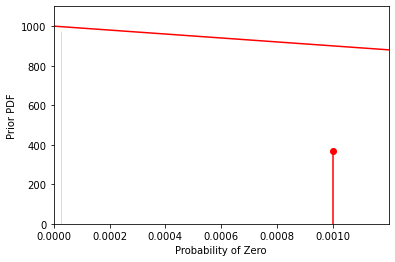

In [68]:
pri = prior(alpha0 = 1, alpha1 = 1000)
pri.plot()

In [69]:
class likelihood:
    def __init__(self, data):
        """Likelihood for binary data."""
        self.counts = {s:0 for s in ['0', '1']}
        self._process_data(data)

    def _process_data(self, data):
        """Process data."""
        temp = [str(x) for x in data]
        for s in ['0', '1']:
            self.counts[s] = temp.count(s)

        if len(temp) != sum(self.counts.values()):
            raise Exception("Passed data is not all 0`s and 1`s!")

    def _process_probabilities(self, p0):
        """Process probabilities."""
        n0 = self.counts['0']
        n1 = self.counts['1']

        if p0 != 0 and p0 != 1:
            # typical case
            logpr_data = n0*np.log(p0) + \
                         n1*np.log(1.-p0)
            pr_data = np.exp(logpr_data)
        elif p0 == 0 and n0 != 0:
            # p0 can't be 0 if n0 is not 0
            logpr_data = -np.inf
            pr_data = np.exp(logpr_data)
        elif p0 == 0 and n0 == 0:
            # data consistent with p0=0
            logpr_data = n1*np.log(1.-p0)
            pr_data = np.exp(logpr_data)
        elif p0 == 1 and n1 != 0:
            # p0 can't be 1 if n1 is not 0
            logpr_data = -np.inf
            pr_data = np.exp(logpr_data)
        elif p0 == 1 and n1 == 0:
            # data consistent with p0=1
            logpr_data = n0*np.log(p0)
            pr_data = np.exp(logpr_data)

        return pr_data, logpr_data

    def prob(self, p0):
        """Get probability of data."""
        pr_data, _ = self._process_probabilities(p0)

        return pr_data

    def log_prob(self, p0):
        """Get log of probability of data."""
        _, logpr_data = self._process_probabilities(p0)

        return logpr_data

In [77]:
class posterior:
    def __init__(self, data, prior):
        """The posterior.

        data: a data sample as list
        prior: an instance of the beta prior class
        """
        self.likelihood = likelihood(data)
        self.prior = prior

        self._process_posterior()

    def _process_posterior(self):
        """Process the posterior using passed data and prior."""

        # extract n0, n1, a0, a1 from likelihood and prior
        self.n0 = self.likelihood.counts['0']
        self.n1 = self.likelihood.counts['1']
        self.a0 = self.prior.a0
        #self.a0 = prior.a0
        self.a1 = self.prior.a1
        #self.a1 = prior.a1
        
        self.p0rv = beta(self.a0 + self.n0,
                         self.a1 + self.n1)

    def interval(self, prob):
        """End points for region of pdf containing `prob` of the
        pdf.

        Ex: interval(0.95)
        """

        return self.p0rv.interval(prob)

    def mean(self):
        """Returns posterior mean."""

        return self.p0rv.mean()
    def pdf(self, p0):
        """Probability density at p0."""

        return self.p0rv.pdf(p0)

    def plot(self):
        """A plot showing prior, likelihood and posterior."""

        f, ax= plt.subplots(3, 1, figsize=(8, 6), sharex=True)
        x = np.arange(0., 1., 0.01)

        ## Prior
        # get prior mean p0
        pri_mean = self.prior.mean()

        # get low/high pts containg 95% probability
        pri_low_p0, pri_high_p0 = self.prior.interval(0.95)
        pri_x_prob = np.arange(pri_low_p0, pri_high_p0, 0.01)

        # plot pdf
        ax[0].plot(x, self.prior.pdf(x), 'r-')

        # fill 95% region
        ax[0].fill_between(pri_x_prob, 0, self.prior.pdf(pri_x_prob),
                           color='red', alpha=0.2 )

        # mean
        ax[0].stem([pri_mean], [self.prior.pdf(pri_mean)],
                   linefmt='r-', markerfmt='ro',
                   basefmt='w-')

        ax[0].set_ylabel('Prior PDF')
        ax[0].set_ylim(0., 1.1*np.max(self.prior.pdf(x)))
        
           ## Likelihood
        # plot likelihood
        lik = [self.likelihood.prob(xi) for xi in x]
        ax[1].plot(x, lik, 'k-')
        ax[1].set_ylabel('Likelihood')

        ## Posterior
        # get posterior mean p0
        post_mean = self.mean()

        # get low/high pts containg 95% probability
        post_low_p0, post_high_p0 = self.interval(0.95)
        post_x_prob = np.arange(post_low_p0, post_high_p0, 0.01)

        # plot pdf
        ax[2].plot(x, self.pdf(x), 'b-')

        # fill 95% region
        ax[2].fill_between(post_x_prob, 0, self.pdf(post_x_prob),
                           color='blue', alpha=0. )

        # mean
        ax[2].stem([post_mean], [self.pdf(post_mean)],
                   linefmt='b-', markerfmt='bo',
                   basefmt='w-')

        ax[2].set_xlabel('Probability of Zero')
        ax[2].set_ylabel('Posterior PDF')
        ax[2].set_ylim(0., 1.1*np.max(self.pdf(x)))

        plt.show() 

<ipython-input-77-e6eb53c2a1c4>:67: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax[0].stem([pri_mean], [self.prior.pdf(pri_mean)],
<ipython-input-77-e6eb53c2a1c4>:96: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax[2].stem([post_mean], [self.pdf(post_mean)],


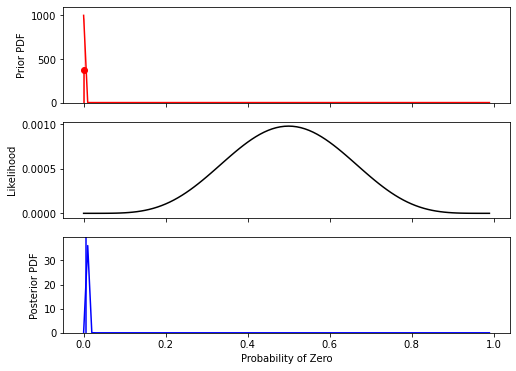

In [78]:
# data
data = [0,1,0,1,0,1,0,1,0,1]

# posterior
post = posterior(data, prior(1,1000))
post.plot()

In [79]:
movies['GG'].mean()

0.005689900426742532

***
***

1. Starting with movies from 1990-1999, define a uniform distribution for prob of a movie winning Best Pic (the initial prior)

(0.0, 0.01)

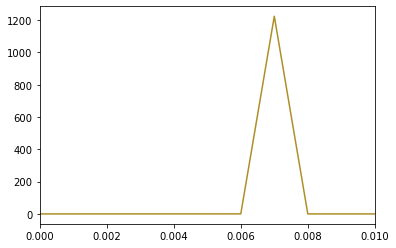

In [11]:
alpha_prior = movies[movies['startYear']<2020]['Oscars'].sum() # number of movies  which were nominated or won for an Academy Award in 2990-2020
beta_prior = movies[movies['startYear']<2020].shape[0] - alpha_prior # number of movies which did not win in that period
prior = stats.beta(alpha_prior, beta_prior) # distribution based on this limited knowledge

plt.plot(np.linspace(0, 1, 1000), prior.pdf(np.linspace(0, 1, 1000)), color = '#ae8e25');
plt.xlim(0,0.01)

In [12]:
prior.mean()

0.006813020439061317

In [13]:
tconst_cluster = pickle.load(open('../pickles/tconst_cluster.p', 'rb'))

2. likelihood???: probability of receiving an Academy nomination, given that the movie already has a Golden Globe nomination

In [14]:
like_ammonite[(like_ammonite['Oscars']==1) & (like_ammonite['GG']==1)].shape[0]/like_ammonite[like_ammonite['GG']==1].shape[0]

0.6171875

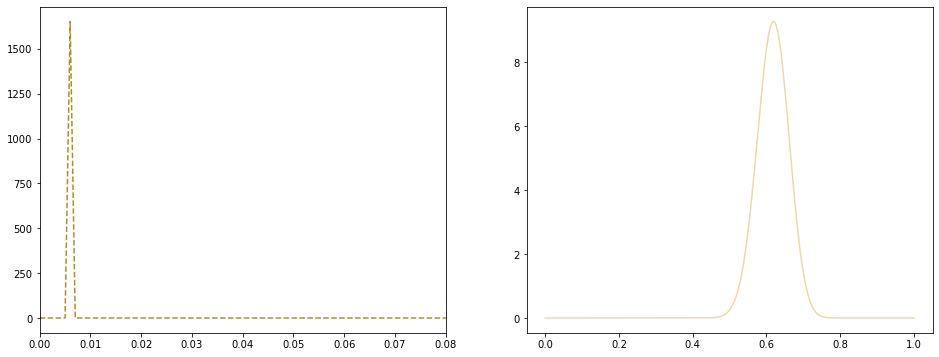

In [15]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
alpha_prior = movies[movies['startYear']<2020]['GG'].sum() # number of movies  which were nominated or won for an Academy Award in 2990-2020
beta_prior = movies[movies['startYear']<2020].shape[0] - alpha_prior # number of movies which did not win in that period
prior_distn = stats.beta(alpha_prior, beta_prior) # distribution based on this limited knowledge
plt.plot(np.linspace(0, 1, 1000), prior_distn.pdf(np.linspace(0, 1, 1000)), color = '#ae8e25', ls = '--')
plt.xlim(0,0.08)

plt.subplot(1,2,2)
alpha_lhood = like_ammonite[(like_ammonite['Oscars']==1) & (like_ammonite['GG']==1)].shape[0] # number of movies  which were nominated or won for an Academy Award in 2990-2020
beta_lhood = like_ammonite[(like_ammonite['Oscars']==0) & (like_ammonite['GG']==1)].shape[0] # number of movies which did not win in that period
likelihood = stats.beta(alpha_lhood, beta_lhood) # distribution based on this limited knowledge

plt.plot(np.linspace(0, 1, 1000), likelihood.pdf(np.linspace(0, 1, 1000)), color = '#ebdaa4');

3. Posterior

In [16]:
prior.pdf(0.008)

0.00012772375322964928

In [17]:
likelihood.pdf(0.65)

7.137377024652714

In [18]:
prior.pdf(0.008)*likelihood.pdf(0.65)

0.0009116125818037117

In [19]:
posterior = np.multiply(prior, likelihood)

TypeError: unsupported operand type(s) for *: 'rv_frozen' and 'rv_frozen'

In [ ]:
def plot_bayes(alpha_prior , beta_prior, alpha_lhood, beta_lhood, steps = 100):
    plt.figure(figsize = (16, 6))
    
    # Generate x values in the appropriate
    # range to use for plotting:
    lst = np.linspace(0, 1, steps)
    
    # Calculating prior, likelihood, and posterior.
    prior = [beta(alpha_prior, beta_prior).pdf(i) for i in lst]
    likelihood = [beta(alpha_lhood, beta_lhood).pdf(i) for i in lst]
    posterior = np.multiply(prior, likelihood)
    
    # Plotting colored lines here to show prior mode, the maximum likelihood value, and posterior mode.
    plt.vlines([(alpha_prior - 1) / (alpha_prior + beta_prior - 2), (alpha_lhood - 1) / (alpha_lhood + beta_lhood - 2) ],
               ymin = 0,
               ymax = max(max(prior), max(likelihood), max(posterior)), # height of dotted lines
               linestyles = 'dashed',
               colors = ['tab:orange', 'tab:green', 'tab:blue'])
    
    # Plotting prior, likelihood, and posterior.
    plt.title("Prior, Likelihood, and Posterior", fontsize = 24)
    plt.plot(lst, prior, c = 'tab:orange', label = 'Prior')
    plt.plot(lst, likelihood, c = 'tab:green', label = 'Likelihood')
    plt.plot(lst, posterior, c = 'tab:blue', label = 'Posterior')
    
    plt.xticks(fontsize = 16)
    plt.yticks([])
    
    # Control y limits.
    plt.ylim(0, min(max(likelihood), max(posterior)) * 1.1) # You can comment this out to see it all on 1 plot.
    #plt.ylim(100)
    plt.legend(fontsize = 18);

In [ ]:
plot_bayes(alpha_prior , beta_prior, alpha_lhood, beta_lhood, steps = 100)

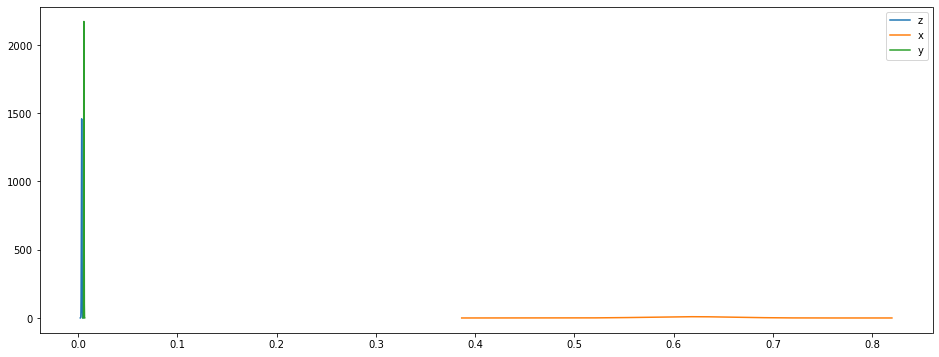

In [22]:
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

N = 100000

y = stats.beta(alpha_prior, beta_prior).rvs(N)
x = stats.beta(alpha_lhood, beta_lhood).rvs(N)
z = x*y
dens_z = sm.nonparametric.KDEUnivariate(z)
dens_z.fit()

dens_x = sm.nonparametric.KDEUnivariate(x)
dens_x.fit()

dens_y = sm.nonparametric.KDEUnivariate(y)
dens_y.fit()

fig, ax = plt.subplots(figsize = (16,6))
ax.plot(dens_z.support, dens_z.density, label='z')
ax.plot(dens_x.support, dens_x.density, label='x')
ax.plot(dens_y.support, dens_y.density, label='y')
ax.legend()
plt.draw_if_interactive()